# Test Runoff Train

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    download_test_jena_data,
    load_test_jena_data_as_dataset
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Open data

In [3]:
ds = xr.open_dataset(base_dir / "data/ALL_dynamic_ds.nc")

# RANDOM subset for training 
stations = np.random.choice(ds.station_id.values, 5)
ds = ds.sel(station_id=stations)
ds

<xarray.Dataset>
Dimensions:         (station_id: 5, time: 16436)
Coordinates:
  * station_id      (station_id) int64 39061 21024 58006 28091 11004
  * time            (time) datetime64[ns] 1970-10-01 1970-10-02 ... 2015-09-30
Data variables:
    precipitation   (time, station_id) float64 ...
    pet             (time, station_id) float64 ...
    temperature     (time, station_id) float64 ...
    discharge_spec  (time, station_id) float64 ...
    discharge_vol   (time, station_id) float64 ...
    peti            (time, station_id) float64 ...
    humidity        (time, station_id) float64 ...
    shortwave_rad   (time, station_id) float64 ...
    longwave_rad    (time, station_id) float64 ...
    windspeed       (time, station_id) float64 ...

In [4]:
cfg = Config(base_dir / "configs/runoff.yml")
cfg._cfg["n_epochs"] = 3
cfg._cfg["scheduler"] = "cycle"
cfg

{'autoregressive': False,
 'batch_size': 256,
 'data_dir': PosixPath('data'),
 'experiment_name': 'runoff',
 'hidden_size': 64,
 'horizon': 0,
 'input_variables': ['temperature', 'precipitation'],
 'learning_rate': 0.01,
 'loss': 'MSE',
 'n_epochs': 3,
 'num_workers': 4,
 'optimizer': 'Adam',
 'pixel_dims': ['station_id'],
 'run_dir': None,
 'scheduler': 'cycle',
 'seed': 1234,
 'seq_length': 356,
 'target_variable': 'discharge_spec',
 'test_end_date': Timestamp('2008-12-31 00:00:00'),
 'test_start_date': Timestamp('1998-01-01 00:00:00'),
 'train_end_date': Timestamp('1997-12-31 00:00:00'),
 'train_start_date': Timestamp('1988-01-01 00:00:00'),
 'validation_end_date': Timestamp('1997-12-31 00:00:00'),
 'validation_start_date': Timestamp('1985-01-01 00:00:00')}

# Train

In [5]:
trainer = Trainer(cfg, ds)

AssertionError: self.constant_mean self.constant_std don't currently work!

In [6]:
losses = trainer.train_and_validate()

Training Epoch 2:   0%|          | 0/54 [00:00<?, ?it/s]

Train Loss: 0.88
Valid Loss: 0.85


Training Epoch 3:   0%|          | 0/54 [00:00<?, ?it/s]

Train Loss: 0.70
Valid Loss: 0.70


Validation Epoch 3: 100%|██████████| 72/72 [00:26<00:00,  2.76it/s]

Train Loss: 0.64
Valid Loss: 0.67


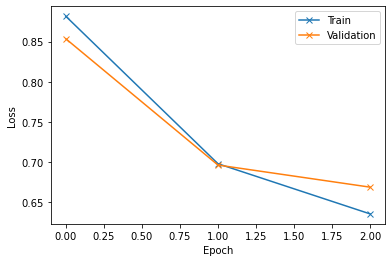

In [7]:
from spatio_temporal.training.eval_utils import _plot_loss_curves

_plot_loss_curves(losses);

# Test

In [8]:
tester = Tester(cfg, ds)

Loading Data: 100%|██████████| 5/5 [00:00<00:00, 48.17it/s]


Test set Forward Pass: 100%|██████████| 72/72 [00:26<00:00,  2.76it/s]


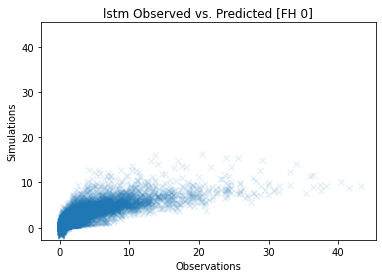

In [9]:
preds = tester.run_test()

In [10]:
preds = preds.drop("horizon")

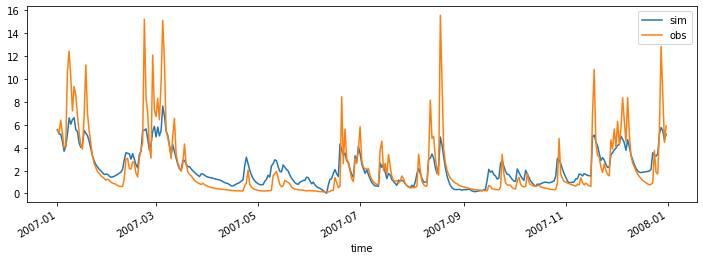

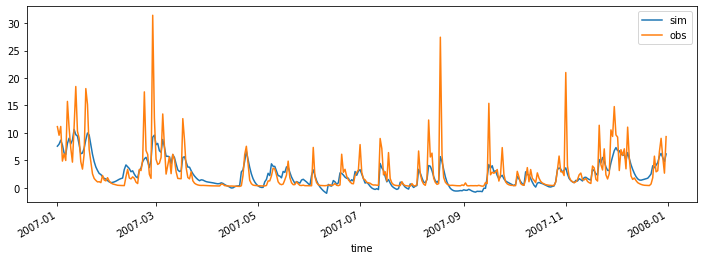

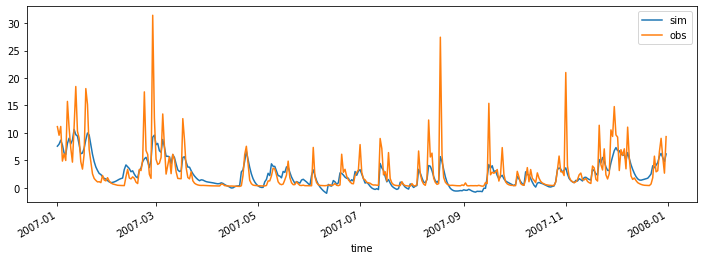

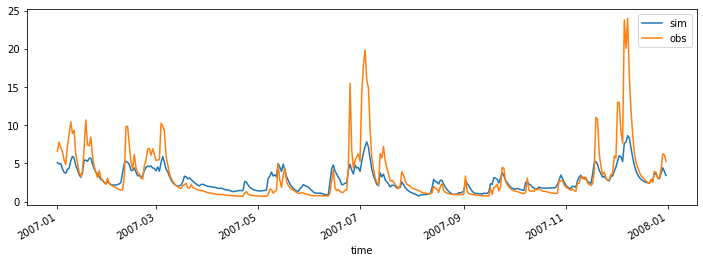

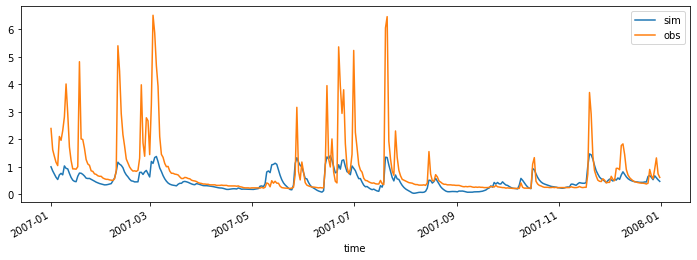

In [11]:
for i in range(5):
    f, ax = plt.subplots(figsize=(12, 4))
    pixel = np.random.choice(preds.pixel.values)
    preds.sel(time="2007", pixel=pixel).to_dataframe().plot(ax=ax)